In [1]:
import numpy as np

In [2]:
from tensorflow import keras
from PIL import Image
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import torch
import random
from torchvision import models, transforms
from scipy.spatial import distance_matrix
from tqdm import tqdm

c:\Users\thors\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [26]:
import sys
root = '../../'
sys.path.append(root)
from HelpfulFunctions.batchCreation import createBatch
from HelpfulFunctions.metrics import meanAveragePrecision

In [33]:
X_train = torch.tensor( np.load( root + "Features/train_features_vgg16_cifar10.npy" ) )
y_train = np.load( root + "Features/train_labels_vgg16_cifar10.npy" )

X_test = torch.tensor( np.load( root + "Features/test_features_vgg16_cifar10.npy" ) )
y_test = np.load( root + "Features/test_labels_vgg16_cifar10.npy" )

------

In [5]:
def getAPN(a, pos, dMatrix, margin):
    aP = [a]+pos
    neg_i = [i for i in range(len(dMatrix)) if i not in aP ]

    outPut = []

    for p in  pos:
        posDist = dMatrix[a][p]
        
        legal_i = [i for i in neg_i if (posDist < dMatrix[a][i]) and (dMatrix[a][i] <= posDist+margin)] # i = "global" index of the Hash
        
        legal_dist = [dMatrix[a][i] for i in legal_i]
        
        if legal_dist == []: continue
        max_dist = min(legal_dist)

        n = legal_i[ legal_dist.index(max_dist) ]
        outPut.append( (a, p, n) )

    return outPut

In [6]:
def customBatch(X_train, y_train, pos_sample_bal, batchSize, pos_label):    
    pos_i = [ i for i in range(len(X_train)) if y_train[i] == pos_label ]
    neg_i = list(set( range(len(X_train)) ) - set(pos_i))

    pos_sample_size = int(batchSize*pos_sample_bal)
    neg_sample_size = batchSize - pos_sample_size

    pos_i = random.sample( pos_i, pos_sample_size)
    neg_i = random.sample( neg_i, neg_sample_size)

    X_sample = torch.stack( [X_train[i] for i in pos_i+neg_i] )
    y_sample = [y_train[i] for i in pos_i+neg_i]
    return X_sample, y_sample

In [7]:
def tripletLoss(bits, margin, batchSize, pos_sample_bal):
    movingAvg_window = 2000
    noImprove_breakVal = 1000
    
    L = []
    mean_loss = 0

    model = nn.Sequential(  nn.Linear(4096,256),
                            nn.ReLU(),
                            nn.Linear(256, bits),
                            nn.Sigmoid()
                            )

    optimizer = optim.Adam( model.parameters() )
    criterion = nn.TripletMarginLoss(p=1, # Manhatten Distance
                                    margin=margin
                                    )

    loss_list = []
    lowest_loss = 10000
    no_improves = 0

    y_unique = list(set(y_train))
    for i in tqdm( range(20000) ):
        if batchSize != None:   xBatch, yBatch = customBatch( X_train, y_train, pos_sample_bal, batchSize, random.sample(y_unique,1)[0] )
        else:                   xBatch, yBatch = createBatch(X_train, y_train, batchSize)

        results = model(xBatch)
        results_np = results.detach().numpy()
        dMatrix = distance_matrix(results_np, results_np, p=1)

        APN_list = []

        for label in set(yBatch):
            pos_i_list = [j for j in range(len(yBatch)) if yBatch[j] == label]
            for anchor_i in pos_i_list:
                pos_i = [j for j in pos_i_list if j != anchor_i]
                APN_list += getAPN(anchor_i, pos_i, dMatrix, margin)

        if len(APN_list) > 0:
            a_list = []
            p_list = []
            n_list = []

            for apn in APN_list:
                a_list.append(results[ apn[0] ])
                p_list.append(results[ apn[1] ])
                n_list.append(results[ apn[2] ])
            
            # === Improve Model ===
            optimizer.zero_grad()
            loss = criterion( torch.stack(a_list), torch.stack(p_list), torch.stack(n_list) )
            loss.backward()
            optimizer.step()

            loss_list.append( float(loss) )
            L.append( float(loss) )
        
        if (i > movingAvg_window):
            while len(L) > movingAvg_window:
                L = L[1:]

            mean_loss = sum(L) / len(L)

            if mean_loss < lowest_loss:
                # print(f"\033[92m {'+'}\033[00m", float(loss))
                lowest_loss = mean_loss
                no_improves = 0
            else:
                # print(f"\033[91m {'-'}\033[00m", float(loss))
                no_improves += 1
            
            if no_improves > noImprove_breakVal: break

        if (i % 500) == 0: 
            #print(f"Make Bacthes + get results: {t2-t1}\n", f"Distance Matrix: {t3-t2}\n", f"MAke APN List: {t4-t3}\n", f"Back Propegate: {t5-t4}")
            
            print(i, mean_loss , no_improves)
        

    return model, loss_list

bits = 32
margin = int(bits / 10)
batchSize = 80
pos_sample_bal = 0.10

model, loss_list = tripletLoss(bits, margin, batchSize, pos_sample_bal)

  0%|          | 3/20000 [00:00<34:04,  9.78it/s]

0 0 0


  3%|▎         | 503/20000 [00:38<23:38, 13.75it/s]

500 0 0


  5%|▌         | 1003/20000 [01:13<23:00, 13.76it/s]

1000 0 0


  8%|▊         | 1503/20000 [01:48<21:20, 14.44it/s]

1500 0 0


 10%|█         | 2003/20000 [02:23<20:43, 14.47it/s]

2000 0 0


 13%|█▎        | 2503/20000 [02:58<20:15, 14.40it/s]

2500 2.019018492817879 8


 15%|█▌        | 3003/20000 [03:33<18:59, 14.92it/s]

3000 2.00559439176321 0


 18%|█▊        | 3503/20000 [04:06<17:12, 15.98it/s]

3500 1.9914389173984528 0


 20%|██        | 4003/20000 [04:41<19:00, 14.02it/s]

4000 1.9832803289294243 45


 23%|██▎       | 4503/20000 [05:15<17:04, 15.13it/s]

4500 1.9758265666365624 21


 25%|██▌       | 5003/20000 [05:49<16:48, 14.88it/s]

5000 1.9639568511247636 12


 28%|██▊       | 5503/20000 [06:23<15:51, 15.23it/s]

5500 1.9584621357321739 211


 30%|███       | 6003/20000 [06:56<16:04, 14.52it/s]

6000 1.951927699804306 4


 33%|███▎      | 6503/20000 [07:30<15:09, 14.84it/s]

6500 1.9423950565457344 4


 35%|███▌      | 7003/20000 [08:04<15:04, 14.37it/s]

7000 1.9429745009541513 390


 38%|███▊      | 7503/20000 [08:37<14:07, 14.75it/s]

7500 1.9382737094163895 51


 40%|████      | 8003/20000 [09:11<13:10, 15.18it/s]

8000 1.9347228163480759 57


 43%|████▎     | 8503/20000 [09:44<12:36, 15.19it/s]

8500 1.9346250066161155 99


 45%|████▌     | 9003/20000 [10:19<12:43, 14.40it/s]

9000 1.9306943076848984 34


 48%|████▊     | 9501/20000 [10:55<13:22, 13.08it/s]

9500 1.9212840554118156 2


 50%|█████     | 10003/20000 [11:33<12:42, 13.10it/s]

10000 1.9165953384041787 222


 53%|█████▎    | 10503/20000 [12:10<11:28, 13.80it/s]

10500 1.908020039945841 0


 55%|█████▌    | 11003/20000 [12:48<10:46, 13.91it/s]

11000 1.900903576105833 83


 58%|█████▊    | 11503/20000 [13:25<10:33, 13.41it/s]

11500 1.895690249413252 99


 60%|██████    | 12003/20000 [14:03<09:35, 13.90it/s]

12000 1.8882393901646137 0


 63%|██████▎   | 12503/20000 [14:41<09:24, 13.27it/s]

12500 1.8850422590970992 22


 65%|██████▌   | 13003/20000 [15:19<08:38, 13.50it/s]

13000 1.8777413983941078 14


 68%|██████▊   | 13503/20000 [15:55<07:33, 14.34it/s]

13500 1.8761985815763473 61


 70%|███████   | 14003/20000 [16:30<06:58, 14.34it/s]

14000 1.8757183173298835 377


 73%|███████▎  | 14503/20000 [17:04<06:05, 15.03it/s]

14500 1.8692964683771134 142


 75%|███████▌  | 15003/20000 [17:36<05:16, 15.81it/s]

15000 1.8631365991830826 12


 78%|███████▊  | 15503/20000 [18:09<04:48, 15.58it/s]

15500 1.8575558170974256 34


 80%|████████  | 16003/20000 [18:41<04:27, 14.92it/s]

16000 1.8532505333721638 0


 83%|████████▎ | 16503/20000 [19:13<03:55, 14.83it/s]

16500 1.8541263475716114 443


 85%|████████▌ | 17003/20000 [19:45<03:06, 16.03it/s]

17000 1.8566983086764812 351


 88%|████████▊ | 17503/20000 [20:17<02:38, 15.73it/s]

17500 1.8582092880010606 851


 88%|████████▊ | 17650/20000 [20:27<02:43, 14.38it/s]


In [8]:
import seaborn as sns
import pandas as pd

c:\Users\thors\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thors\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: >

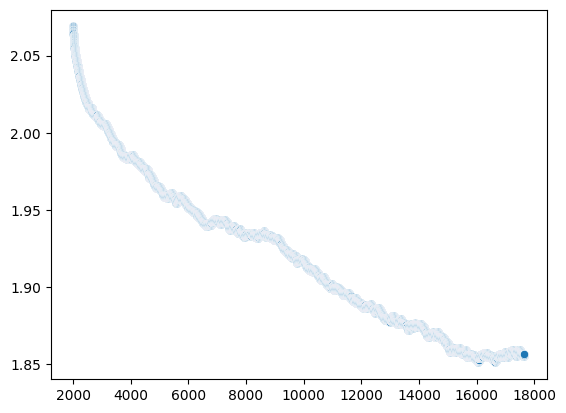

In [9]:
window_size = 2000
 
# Convert array of integers to pandas series
numbers_series = pd.Series(loss_list)
 
# Get the window of series
# of observations of specified window size
windows = numbers_series.rolling(window_size)
 
# Create a series of moving
# averages of each window
moving_averages = windows.mean()

sns.scatterplot(y=moving_averages, x=list(range(len(moving_averages))))

----

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Step 1: Perform K-Means Clustering
def kmeans_clustering(hash_codes, n_clusters=10, n_init=10, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    clusters = kmeans.fit_predict(hash_codes)
    return clusters

# Step 2: Build the label-cluster matrix
def build_label_cluster_matrix(clusters, true_labels, n_clusters=10):
    # Initialize a matrix to count label-cluster relationships  
    label_cluster_matrix = np.zeros((10, n_clusters), dtype=int)
    
    for label, cluster in zip(true_labels, clusters):
        label_cluster_matrix[label][cluster] += 1
    
    return label_cluster_matrix

# Step 3: Visualize the result as a heatmap
def plot_heatmap(label_cluster_matrix):
    plt.figure(figsize=(10, 6))
    sns.heatmap(label_cluster_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Label Distribution Across Clusters")
    plt.xlabel("Clusters")
    plt.ylabel("True Labels")
    plt.show()


def easyHeatmap(hashCodes, labels):
    raw_clusters = kmeans_clustering(hashCodes, n_clusters=10)

    raw_label_cluster_matrix = build_label_cluster_matrix(raw_clusters, labels)

    plot_heatmap(raw_label_cluster_matrix)

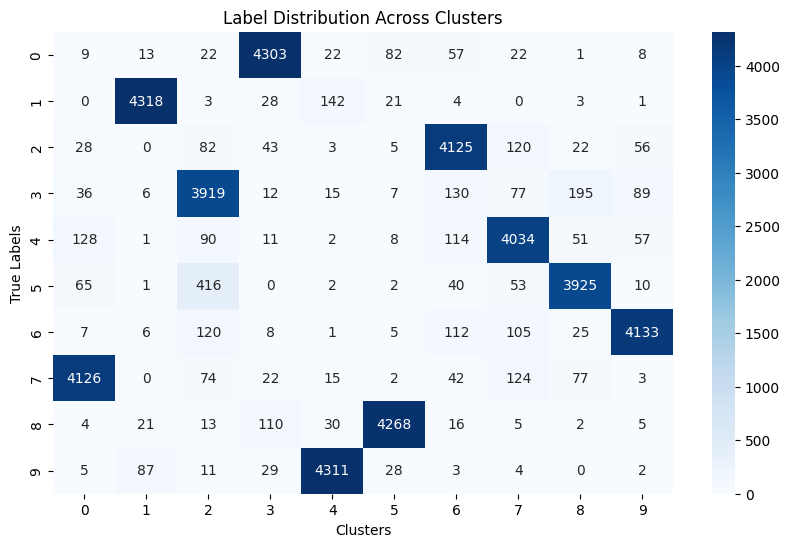

In [11]:
easyHeatmap(model(X_train).detach().numpy(), y_train)

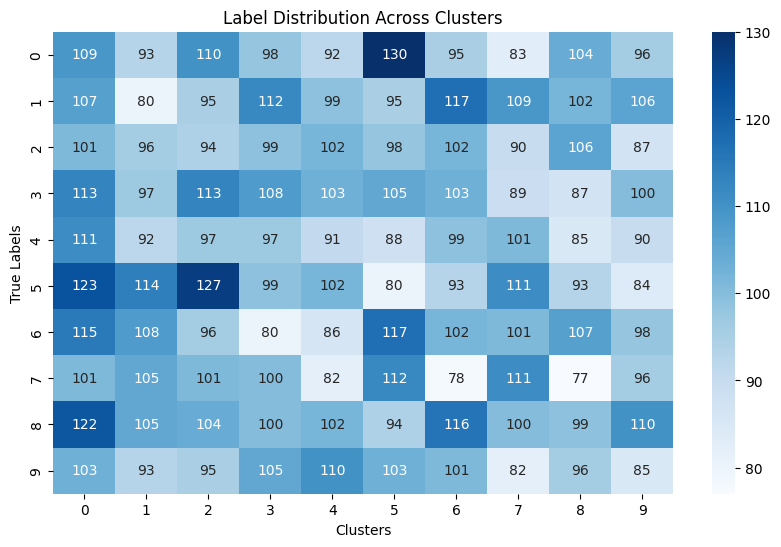

In [12]:
easyHeatmap(model(X_test).detach().numpy(), y_train)

In [19]:
hash_train = (model(X_train).detach().numpy() > 0.5).astype(int)
hash_test = (model(X_test).detach().numpy() > 0.5).astype(int)
hash_test

array([[0, 0, 0, ..., 1, 1, 0],
       [1, 0, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 1, 0, 0],
       ...,
       [1, 1, 0, ..., 1, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 1, 0]])

In [25]:
type(hash_train)

numpy.ndarray

In [28]:
def meanAveragePrecision(test_hashes, training_hashes, test_labels, training_labels):
    aps = []
    for i, test_hash in enumerate(tqdm(test_hashes)):
        label = test_labels[i]
        distances = np.abs(training_hashes - test_hashes[i]).sum(axis=1)
        tp = np.where(training_labels==label, 1, 0)
        hash_df = pd.DataFrame({"distances":distances, "tp":tp}).reset_index()
        hash_df = hash_df.sort_values(["distances", "index"]).reset_index(drop=True)
        hash_df = hash_df.drop(["index", "distances"], axis=1).reset_index()
        hash_df = hash_df[hash_df["tp"]==1]
        hash_df["tp"] = hash_df["tp"].cumsum()
        hash_df["index"] = hash_df["index"] +1 
        precision = np.array(hash_df["tp"]) / np.array(hash_df["index"])
        ap = precision.mean()
        aps.append(ap)
    
    return np.array(aps).mean()

In [29]:
meanAveragePrecision( hash_test , hash_train, y_test, y_train)

100%|██████████| 10000/10000 [03:35<00:00, 46.38it/s]


0.8346580800626933

In [30]:
def p_at_k(test_hashes, training_hashes, test_labels, training_labels, ks):
    k_dic = {k:[] for k in ks}
    for i, test_hash in enumerate(tqdm(test_hashes)):
        label = test_labels[i]
        distances = np.abs(training_hashes - test_hashes[i]).sum(axis=1)
        tp = np.where(training_labels==label, 1, 0)
        hash_df = pd.DataFrame({"distances":distances, "tp":tp}).reset_index()
        hash_df = hash_df.sort_values(["distances", "index"]).reset_index(drop=True)
        for k in ks:
            df_temp = hash_df[:k]
            patk = df_temp["tp"].sum()/k
            k_dic[k].append(patk)
    return tuple([np.array(k_dic[k]).mean() for k in ks])

In [32]:
p_at_k(hash_test , hash_train, y_test, y_train, [100, 1000, 2500, 5000, 10000])

100%|██████████| 10000/10000 [03:19<00:00, 50.24it/s]


(0.8301280000000001, 0.8372088, 0.83837348, 0.7346974999999999, 0.41318904)